In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import matplotlib as mpl
import matplotlib.cm as cm
import cPickle as pickle
import helpers
import plots
import pandas as pd
import glob
import plot_ts
reload(plots)
reload(helpers)

<module 'helpers' from 'helpers.pyc'>

# Figure 1 notebook

In [2]:
## Load posterior mean dataframe
df = pickle.load(open('pm_df.p', 'rb'))
print df.dtypes

mpl.rcParams.update({'font.size': 16})

theta1      float64
theta2      float64
theta3      float64
theta4      float64
theta5      float64
theta6      float64
theta7      float64
theta8      float64
drug         object
dose        float64
adlib        object
period       object
id            int64
duration      int64
filename     object
filepath     object
rate        float64
x0           object
drug_c       object
rate_c       object
ms           object
dtype: object


## Figure 1B: Fullness is highly indicative of feeding behaviour and can be used to predict the intermeal interval

61183 61183 61183
61183 61183 61183


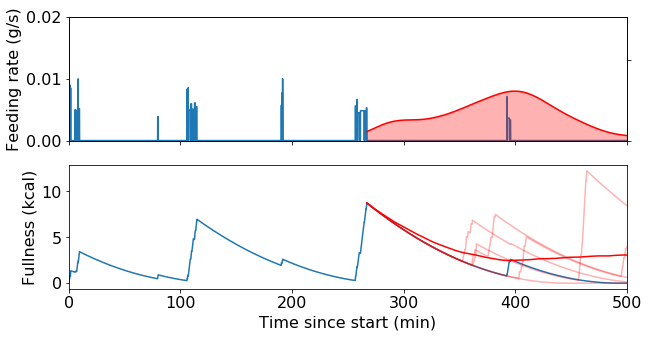

In [3]:
reload(plots)
import fwd_likelihoods as fl
reload(fl)
## Sampling parameters
predict_index = 26 # 26 is good
num_samples = 1000
tmax = 4*60*60

## Get subject data
subj_file = 'saline_0.0_A_L_5_20_2015-11-23.B0105.CSV'
subj_path = '_'.join(subj_file.split('_')[:4])
subj_path = 'new_all_data/' + subj_path + '/'
filepath = subj_path + subj_file
data = np.loadtxt(filepath, delimiter='\t', usecols=(0,1,2,3,4))

## Get subject posterior
post_info = subj_file.split('_')

idx1 = (df['drug'] == post_info[0]) & (df['dose'] == float(post_info[1]))
idx2 = (df['adlib'] == post_info[2]) & (df['period'] == post_info[3])
idx3 = (df['id'] == int(post_info[4]))
animal_df = df[idx1 & idx2 &idx3]

## Convert from transformed parameters
thetas = ['theta1', 'theta2', 'theta3', 'theta4', 'theta5', 'theta6', 'theta7', 'theta8']
pm_theta = np.array(animal_df[thetas])[0]
theta7 = np.power(10., np.array(animal_df['theta7'])[0])
theta8 = np.power(10., np.array(animal_df['theta8'])[0])

## Do the plotting
fig, axes, ax2 = plots.timeseries_predict_plot(data, 
                                          pm_theta,
                                          predict_index, 
                                          num_samples,
                                          tmax)

#axes[0].set_xlim([-500, 30000]) # in seconds
#axes[1].set_xlim([-500, 30000])
#ax2.set_xlim([-500, 30000])
axes[0].set_xlim([0, 500]) # in minutes
axes[1].set_xlim([0, 500])
ax2.set_xlim([0, 500])
axes[0].set_xticklabels([])
axes[1].set_xlabel('Time since start (min)')
axes[0].set_ylabel('Feeding rate (g/s)')
axes[1].set_ylabel('Fullness (kcal)')
#ax2.set_ylabel('P(meal start)')
#fig.tight_layout()
plt.savefig('figures/1B.svg')
plt.show()

61183 61183 61183
61183 61183 61183


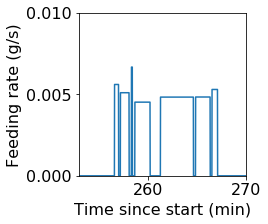

In [4]:
reload(plots)

fig, axes = plots.timeseries_inset(data, 26)
axes.set_xlim([253, 270])
axes.set_ylim([0, 0.01])
axes.set_yticks([0, 0.005, 0.01])
axes.set_xlabel('Time since start (min)')
axes.set_ylabel('Feeding rate (g/s)')
plt.savefig('figures/1B_inset.svg')
plt.show()

## Figure 1C: Model fit to microscopic feeding behaviour yields long-term calorie intakes that match those observed across a range of nutritional states, anorectic drugs and photoperiods

2.5618280754488034 8 new_all_data/LiCl_64.0_R_L 2014-10-27.B0111.CSV
1.5380483316241973 8 new_all_data/saline_0.0_R_D 2015-11-23.B0107.CSV
1.8948521124381923 8 new_all_data/saline_0.0_A_L 2015-11-23.B0114.CSV
1.8337879957123813 8 new_all_data/LiCl_32.0_R_L 2014-10-17.B0106.CSV
2.427918938084949 8 new_all_data/saline_0.0_R_L 2014-11-10.B0104.CSV
2.030455395377781 8 new_all_data/saline_0.0_R_L 2014-11-10.B0108.CSV
1.8219786433782812 8 new_all_data/saline_0.0_R_L 2015-11-23.B0112.CSV
0.7832912723088119 2.4517113941303913e-65
0.7065379789247536 0.6288684136871459


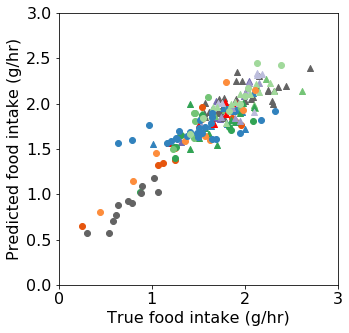

In [5]:
import fwd_sample as fs
from scipy import stats
reload(plots)
reload(fs)
reload(helpers)

num_samples = 100

fig, axes = plt.subplots(1, figsize=(5,5))

true_vals = []
post_predicts = []

## Posterior predictive check function
def ppc(row):
    theta = np.array(row[thetas])
    #duration = row['duration']
    #rate = row['rate']
    c = row['drug_c']
    ms = row['ms']
    x0 = float(row['x0'])
    
    duration = 8
    samples = []
    for i in range(0, num_samples):
        samples.append(fs.sample(3600*duration, theta, x0)[1])
        
    samples = np.array(samples)
    post_predict = np.mean(samples/duration)
    
    filename = helpers.get_filename(row)
    filepath = row['filepath']
    rate = helpers.amt_to_time(filepath, filename, 3600*duration)
    rate = rate/duration
    
    if post_predict/rate > 1.5:
        print post_predict/rate, duration, row['filepath'], row['filename']
    axes.scatter(rate, post_predict, c=c, marker=ms)
    ppc_err = np.std(samples/duration)
    """
    axes.errorbar(rate, 
                  post_predict, 
                  yerr=ppc_err, 
                  fmt='o',
                  ecolor=c, 
                  color=c, 
                  marker=ms)    
    """
    
    true_vals.append(rate)
    post_predicts.append(post_predict)
    
# Iterate through the posterior means and plot
df.apply(ppc, axis=1)

## Visual guide for accuracy
x = np.linspace(0, 2.6, 10)
#axes.plot(x, x, c='k', ls='--')

axes.set_xlim([0, 3])
axes.set_ylim([0, 3])

## Goodness of fit check
slope, intercept, r_value, p_value, std_err = stats.linregress(true_vals, post_predicts)
print r_value**2, p_value
print slope, intercept
#axes.plot(x, intercept + slope*x, c='r', ls='--')
axes.set_xlabel('True food intake (g/hr)')
axes.set_ylabel('Predicted food intake (g/hr)')

## Save figure
#fig.tight_layout()
plt.savefig('figures/1C.svg')

plt.show()

## Figure 1D: ethogram

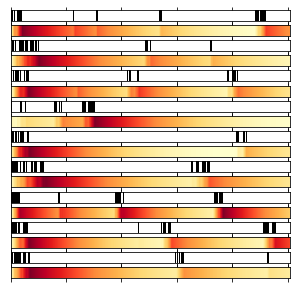

In [6]:
reload(plots)
reload(helpers)

folder = 'new_all_data/saline_0.0_R_L/'
plots.plot_ethogram(folder, 9, maxlen=7*3600, ysize=100)

## Save figure
fig.tight_layout()
plt.savefig('figures/1D.svg')

plt.show()

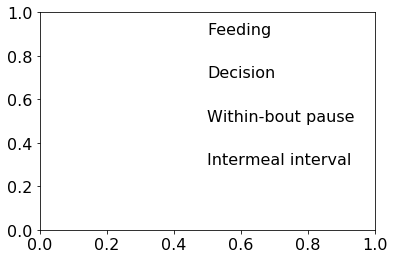

In [7]:
fig, axes = plt.subplots(1)
axes.text(0.5, 0.9, 'Feeding')
axes.text(0.5, 0.7, 'Decision')
axes.text(0.5, 0.5, 'Within-bout pause')
axes.text(0.5, 0.3, 'Intermeal interval')
plt.savefig('figures/fig1a_annotations.svg')
plt.show()